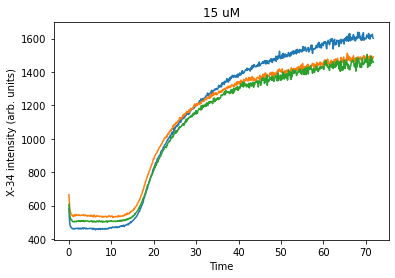

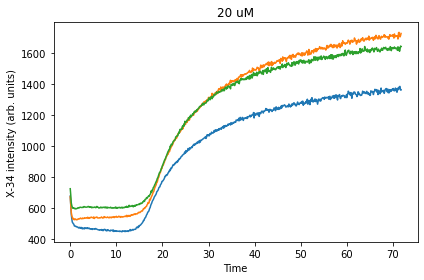

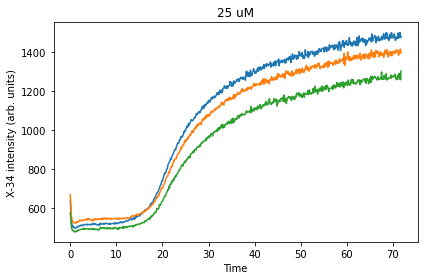

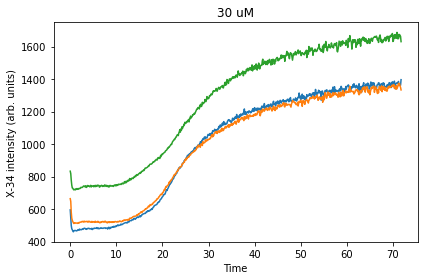

<Figure size 432x288 with 0 Axes>

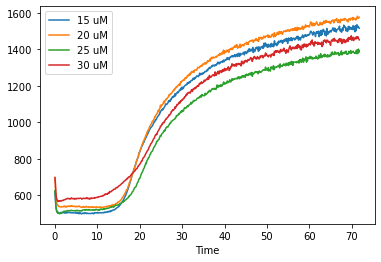

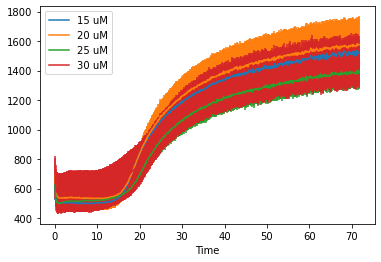

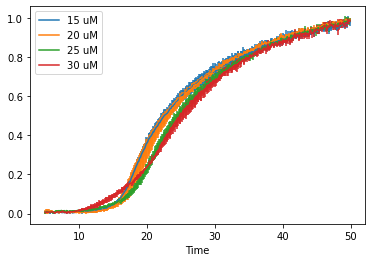

In [1]:
#TODO: check if import sts could be optimized only importing used functions
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import tkinter as tk
from tkinter import ttk

## main functions

# retrieve documents' addresses + add them to a dict 
def document_retrieval():
    doc_dict = {}
    number_of_docs = int(input('How many documents will you merge? '))
    
    for i in range(0, number_of_docs):
        doc_dict['doc_' + str(i + 1)] = input('Paste the full address  of document # ' + str(i + 1))
    
    return doc_dict

# aim: renaming columns to letter+number format from FLUOstar
#this really could be improved
def column_rename(df):
    for i in range(1,97):
        letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
        if int(i%12) == 0:
            letter = letters[int(i/12)-1]
            number = 12
        else:
            letter = letters[int(i/12)]
            number = i%12
    
        df.columns.values[i] = letter + str(number)   
    
    return df

# getting number of rows in doc for preprocessing/adding conditions later on (I think...)
def row_numbers(df):
    row_number = len(df.index)
    df.index = range(1, row_number + 1)
    return df


# preprocessing of datasets: dropping top rows and naming TIME column.
def preprocessing(df):
    df = df.drop([0,1,2,3,4,5,6], axis=0)
    df = df.drop(columns=['User: USER'])
    df = df.rename({'Unnamed: 1': 'Time'}, axis=1) 
    df = column_rename(df)
    df = df.astype(float)
    df = row_numbers(df)
    return df

# add final time of previous dataframe to time column of next dataframe
def time_column_update(first_df, second_df):
    current_last_time = first_df['Time'][first_df.index[-1]]
    second_df['Time'] = second_df['Time'].apply(lambda x: x + current_last_time)
    return second_df

# create full time column for the entire experiment
def time_processing_doc():
    all_docs_final = {}
    all_docs_preproc_keys = list(all_docs_dict_preprocessed.keys())
    
    for i in range(0, len(all_docs_preproc_keys)):
        if i==0:
            key_value = all_docs_preproc_keys[i]
            all_docs_final[key_value] = all_docs_dict_preprocessed[key_value]
        
        elif i>0:
            first_key_value = all_docs_preproc_keys[i-1]
            second_key_value = all_docs_preproc_keys[i]
            first_doc_db = all_docs_dict_preprocessed[first_key_value]
            second_doc_db = all_docs_dict_preprocessed[second_key_value]
            all_docs_final[second_key_value] = time_column_update(first_doc_db, second_doc_db)
            
    return all_docs_final

# concantenate all docs in one dataframe
def concatenate_docs():
    all_docs = []

    for i in all_docs_final_dict.keys():
        current_final_doc = all_docs_final_dict[i]
        all_docs.append(current_final_doc)
    
    return all_docs

# asks for user input regarding columns that belong to the (current) group/condition
def choose_groups():
    columns_string = input("Write the name of the columns that belong to this group as the cell name (ex. B2 B3 B4), separated by spaces: ")
    columns_list = columns_string.split(" ")

    # QC: check for unique column names + valid names
    # finally check if name is unique
    for name in columns_list:
        name_regex = re.search("\A[a-h][1-9]$|\A[a-h]1[0-2]$", name, re.IGNORECASE)
        if name_regex == False:
            print("The column" + name + "does not match the correct naming pattern (ex. B4, c2). Please, enter the columns for this condition again" )
            columns_string = input("Write the name of the columns that belong to this group as the cell name (ex. B2 B3 B4), separated by spaces: ")

    return columns_list

# creates condition groups + columns that belong in them by asking for user input
# this needs optimization but works
def create_groups():
    conditions_groups = {}
    entering_groups_active = True
   
    while entering_groups_active:
        group_name = input("Write a name for this group of columns: ")
        columns_list = choose_groups()

        # QC for unique names
        conditions_groups_list = list(conditions_groups.values())
        for column in columns_list:
            if column in conditions_groups_list:
                print("It seems as if one or more of the columns have already been chosen. Please enter the columns for this condition again.")
                columns_list = choose_groups()

        conditions_groups[group_name] = columns_list

        # new group input + answer check
        new_group = input("Would you like to add another group? (y/n) ").lower()
        if new_group == 'y' or new_group == 'yes':
            entering_groups_active = True
        elif new_group == 'n' or new_group == 'no':
            entering_groups_active = False
        else:
            print("You must write 'y' (without ticks) if you want to add another group, and 'n' (without ticks) if you do not wish to do so")
            new_group = input("Would you like to add another group? (y/n) ")
            if new_group == 'y' or new_group == 'yes':
                entering_groups_active = True
            elif new_group == 'n' or new_group == 'no':
                entering_groups_active = False
    
    return conditions_groups

# retrieves which wells will be kept on df according to chosen columns by user
def get_wells_to_keep(conditions_groups):
    chosen_wells = []
    
    for conditions in conditions_groups.values():
        for i in range(len(conditions)):
            chosen_wells.append(conditions[i].upper())
            
    return chosen_wells

# eliminates wells that do not belong to any group/condition
def drop_unused_wells(df, wells_list):
    columns_df = list(df.columns)
    
    for well in columns_df[1:]:
        if str(well) not in wells_list:
            del df[well]
    
    return df

# creates plots for every condition, showing all columns for each one
def create_first_plots():
    
    full_plots_dic = {}
    axs_dic = {}
    time_col = full_doc['Time']
    fluorophore = input('Which fluorophore was used? ')
        
    for group in conditions_groups.keys():
        first = conditions_groups.get(group)[0].upper()
        second = conditions_groups.get(group)[1].upper()
        third = conditions_groups.get(group)[2].upper()
        full_plots_dic[group + '_plot'] = plt.plot(time_col, full_doc[first], time_col, full_doc[second], time_col, full_doc[third], label=group)
        plt.xlabel('Time')
        plt.ylabel(fluorophore + ' intensity (arb. units)')
        plt.title(str(group))
        full_plots_fig = plt.figure(tight_layout=True)
        
    return full_plots_dic

# deletes wells (after user input) if its needed (ex. if a replicate seems wrong)
def deleting_wells(wtk):
    wtk_up = wtk[:]
    delete_wells_active = True
    wells_to_del_list = []
    
    # get input for wells to be deleted
    while delete_wells_active:
        delete_answer = input("Do you want to delete any well? (y/n) ")
        if delete_answer.lower() == 'y' or delete_answer.lower() == 'yes':
            wells_to_del = input('Which wells? Write them separated by a space ')
            wells_to_del_list = wells_to_del.split(" ")
        elif delete_answer.lower() == 'n' or delete_answer.lower() == 'no':
            delete_wells_active = False
        else:
            print("You must write 'y' (without ticks) if you want to delete any wells, and 'n' (without ticks) if you do not wish to do so")
            delete_answer = input("Do you want to delete any well? (y/n) ")
            if delete_answer.lower() == 'y' or delete_answer.lower() == 'yes':
                delete_wells_active = True
            elif delete_answer.lower() == 'n' or delete_answer.lower() == 'no':
                delete_wells_active = False
      
        # delete chosen wells
        for well in wells_to_del_list:
            if well.upper() in wtk_up:
                wtk_up.remove(well.upper())
                
    return wtk_up

# update groups taking out deleted wells
def update_conditions_groups(cg):
    
    for condition, values in cg.items():
        value_list = values[:]
        for item in value_list:
            if item.upper() not in wells_to_keep_updated:
                print(item)
                values.remove(item)
                
    return cg

#changes name of columns according to group/condition name
def change_column_names(df):
    column_names = {}
    new_df = df.copy()
    new_df = new_df.set_index('Time')
    
    for key, value in conditions_groups.items():
        for i in range(0, len(value)):
            column_names[value[i]] = key
    
    for df_column in list(new_df.columns):
        for key, value in column_names.items(): 
            if df_column.lower() == key.lower():
                new_df.rename(columns = {df_column: value}, inplace = True)
            elif df_column.lower() == key.lower() + "_std":
                new_df.rename(columns = {df_column: value + '_std'}, inplace = True)
    
    return new_df

# returns df with averages for each group/condition
def averages_df_gen(df):
    
    averages_df =df.groupby(level=0,axis=1).mean()        
    return averages_df

# returns df with standar deviations for each group/condition
def stdev_df_gen(df):
    
    stdev_df =df.groupby(level=0,axis=1).std()
            
    return stdev_df

# returns df with averages + standar deviations for each condition (general format for each condition: ave column - stdev column)
def merge_ave_std(ave_df, std_df):
    ini_col = len(conditions_groups)
    num = 1
    
    for i in range(0, ini_col):
        std_col = std_df.columns[i]
        if i == 0:
            ave_col = ave_df.columns[i]
            if ave_col == std_col:
                ave_df.insert(i + 1, (std_df.columns[i] + '_std'), std_df[std_df.columns[i]])
        else:
            ave_col = ave_df.columns[i + num]
            if ave_col == std_col:
                ave_df.insert(i+num+1, (std_df.columns[i] + '_std'), std_df[std_df.columns[i]])
                num += 1
    
    return ave_df

# asks user input for initial and final times for normalization of each column/replicate
def get_norm_times(df):
    times_norm = {}
    new_df = df.copy() 
    
    for i in range(1, len(df.columns)):
        ini_time = int(input('Enter initial time for normalization of column ' + str(df.columns[i] )))
        final_time = int(input('Enter final time for normalization of column ' + str(df.columns[i] )))
        times_norm[new_df.columns[i]] = [0]*2
        times_norm[new_df.columns[i]][0] = ini_time
        times_norm[new_df.columns[i]][1] = final_time 
                         
    return times_norm      

# returns normalized df using initial and final times input by user
def normalization(df): 
    
    for i in range(0, len(df.columns) - 1):
        #look for initial and final chosen times
        column_in_dic = list(times_norm_dic.keys())[i]
        ini_time = times_norm_dic[column_in_dic][0]
        final_time = times_norm_dic[column_in_dic][1]
        
        #look for indexes that match ini and final times in Time column
        ini_index = df.loc[df['Time'] == ini_time].index[0]
        final_index = df.loc[df['Time'] == final_time].index[0]
        
        #look for max and min values in df column within range= ini_index-final_index
        max_value = df.iloc[ini_index:final_index, i+1].max()
        min_value = df.iloc[ini_index:final_index, i+1].min()
        subs_max_min  = max_value - min_value

        final_index_norm = final_index + 1
        
        #normalize each value in sample column
        for k in range(ini_index, final_index_norm):
            current_value = df.at[k, column_in_dic]
            df.at[k, column_in_dic] = (current_value - min_value)/subs_max_min
        
    #get lowest and highest times used in df
    lower_times = []
    highest_times = []
    
    for condition in list(times_norm_dic.keys()):
        lower_time = times_norm_dic[condition][0]
        highest_time = times_norm_dic[condition][1]
        lower_times.append(lower_time)
        highest_times.append(highest_time)
    
    min_time = min(lower_times)
    max_time = max(highest_times)
    min_index = df.loc[df['Time'] == min_time].index[0]
    max_index = df.loc[df['Time'] == max_time].index[0]
    last_index = len(df.index)
    min_index_updated = min_index
    max_index_updated = max_index - min_index_updated
    last_index_updated = last_index - min_index_updated + 1
    first_range = range(0, (min_index + 1))
    last_range = range(max_index_updated, (last_index_updated + 1))
    df.drop(df.iloc[0:min_index_updated].index, inplace=True)
    df.drop(df.iloc[max_index_updated:last_index_updated].index, inplace=True)

    
    return df

# calculate half-times for each column/replicate and returns a df (format: column with each replicate in rows - half times)
def half_times_df(df):
    
    val = 0.5
    
    half_times = df.sub(val).abs().idxmin()
    
    return half_times


#################################################################################################################################

## full sequence 

# retrieve all documents
all_docs_dict = document_retrieval()
all_docs_keys = all_docs_dict.keys()
all_docs_dict_preprocessed = {}

# add documents to dictionary with all docs preprocessed
for i in all_docs_keys:
    current_doc_add = all_docs_dict[i]
    current_doc_db = pd.read_excel(current_doc_add)
    all_docs_dict_preprocessed[i] = preprocessing(current_doc_db)

# check what is this truly doing
all_docs_final_dict = time_processing_doc()
all_docs_list = concatenate_docs()

# create full docs with all docs all preprocessed
full_doc = pd.concat(all_docs_list)

# ask and create conditions groups with replicates + define wells/columns to be kept
conditions_groups = create_groups()
wells_to_keep = get_wells_to_keep(conditions_groups)

# eliminate unused wells from full docs
full_doc = drop_unused_wells(full_doc, wells_to_keep)

# show plots for all conditions using all wells
create_first_plots()

# ask user if any wells will be deleted and update full doc df + condition group dict accordingly
wells_to_keep_updated = deleting_wells(wells_to_keep)
full_doc = drop_unused_wells(full_doc, wells_to_keep_updated)
conditions_groups_up = conditions_groups.copy()
conditions_groups_up = update_conditions_groups(conditions_groups_up)

# change name of full doc creating a new updated df
full_doc_good_names = change_column_names(full_doc)

# generate df with average for all conditions
averages_df = averages_df_gen(full_doc_good_names)

# generate plot with averages
average_plot = averages_df.plot()

# generate df with standar deviations for all conditions
stdev_df = stdev_df_gen(full_doc_good_names)

# generate plot with averages + std deviations
average_plot_sd = averages_df.plot(yerr=stdev_df)

# generate df with both averages and standar deviations
averages_std_df = merge_ave_std(averages_df, stdev_df)

# ask user input for initial and final times for normalization of each replicate, put info in a dictionary
times_norm_dic = get_norm_times(full_doc)

# generate df with normalized data
norm_df = full_doc.copy()
norm_df = norm_df.reset_index(drop=True)
norm_df = normalization(norm_df)
norm_df = change_column_names(norm_df)

# generate df with averages of normalized data
norm_averages_df = averages_df_gen(norm_df)
# generate df with standar deviations of normalized data
norm_stdev_df = stdev_df_gen(norm_df)

# plot normalized data (averages + stdev)
norm_average_plot = norm_averages_df.plot(yerr=norm_stdev_df)

# generates df with averages + stdevs of normalized data
norm_ave_std_df = merge_ave_std(norm_averages_df, norm_stdev_df)

# check what is happ here---
norm_std_ave_df = averages_df_gen(norm_stdev_df)


# calculate half-times + generate df with them
half_times = half_times_df(norm_df)
half_times = half_times.reset_index()
half_times = half_times.rename(columns={half_times.columns[0]: 'Condition', half_times.columns[1]: 'half-times'})

# calculate and generate averages + std devs for half times
half_times_ave = half_times.groupby(by='Condition').mean()
half_times_stdev = half_times.groupby(by='Condition').std()
half_times_stdev = half_times_stdev.rename(columns={half_times.columns[1]: 'half-times stdev'})
ht_std_column = half_times_stdev['half-times stdev']
half_times_ave_std = half_times_ave.join(ht_std_column)

# generate final excel file
final_doc_name = input('Name for the final Excel document: ')

with pd.ExcelWriter(final_doc_name + '.xlsx') as writer:
    full_doc_good_names.to_excel(writer, sheet_name="Full")  
    averages_std_df.to_excel(writer, sheet_name="Averages")  
    norm_df.to_excel(writer, sheet_name="Normalized")  
    norm_ave_std_df.to_excel(writer, sheet_name="Normalized (ave)")
    half_times.to_excel(writer, sheet_name="half-times")
    half_times_ave_std.to_excel(writer, sheet_name="half-times (ave)")

In [2]:
## FOR TESTING

#first_doc = C:\Users\alnair\Desktop\2022_02_21_TADC_benchmarking_highconc\20220221_TADC_benchmarking_higher_conc_01.xlsx
#second_doc = C:\Users\alnair\Desktop\2022_02_21_TADC_benchmarking_highconc\20220221_TADC_benchmarking_higher_conc_02.xlsx
#third_doc = C:\Users\alnair\Desktop\2022_02_21_TADC_benchmarking_highconc\20220221_TADC_benchmarking_higher_conc_03.xlsx

In [3]:
## GUI

# window

# create window
root = tk.Tk()
root.title("Tkinter window demo")

# specify window's measures and location
root_width = 600
root_height = 425

screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()

center_x = int(screen_width/2 - root_width/2)
center_y = int(screen_height/2 - root_height/2)

root.geometry(f'{root_width}x{root_height}+{center_x}+{center_y}')

# stacking fixed on top
root.attributes('-topmost', 1)

root.mainloop()